# TP2 de robótica

Caio Teles Cunha 2020006434

Ivan 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.image as mpimg
import matplotlib.patches as patches
import networkx as nx
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [2]:
def Rx(theta):
 
    return np.array([[  1, 0            , 0           ],
                      [ 0, np.cos(theta),-np.sin(theta)],
                      [ 0, np.sin(theta), np.cos(theta)]])
  
def Ry(theta):
 
    return np.array([[  np.cos(theta), 0, np.sin(theta)],
                      [ 0            , 1, 0           ],
                      [-np.sin(theta), 0, np.cos(theta)]])


def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

# Plota um referencial no plano
def plot_frame(Porg, R, c=None):

    axis_size = 1.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
    
    if c == None:
        c = ['r', 'g']
    
    # X
    plt.quiver(*Porg[0:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[0:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

## Funções para obter posição, angulos de euler e plotar referenciais

In [3]:
def getPosition(handleObject):
    position = sim.getObjectPosition(handleObject)
    position = np.array(position)
    return position

In [4]:
def getEulerAngles(handleObject):
    eulerAngles = sim.getObjectOrientation(handleObject)
    eulerAngles = np.array(eulerAngles)
    return eulerAngles

In [5]:
def getRelativePosition(handleObject,handleReference):
    position = sim.getObjectPosition(handleObject,handleReference)
    position = np.array(position)
    return position

In [6]:
def getRelativeEulerAngles(handleObject,handleReference):
    eulerAngles = sim.getObjectOrientation(handleObject,handleReference)
    eulerAngles = np.array(eulerAngles)
    return eulerAngles

In [7]:
def plotFrame(position,eulerAngles):
    # Frame Object
    Porg = np.array(position)    
    R = Rz(eulerAngles[2])
    plot_frame(Porg, R)

In [8]:
# (firstFrame -> second frame)
# T (secondFrame,fistFrame)
# Ao multiplicar um ponto do primeiro frame, ele se transforma em um ponto em relação
# ao segundo frame
def getTransformationMatrix(fistFrameHandle,secondFrameHandle):

    fistFramePosition = getRelativePosition(fistFrameHandle,secondFrameHandle)
    fistFrameOrientation = getRelativeEulerAngles(fistFrameHandle,secondFrameHandle)

    Rsf = Rz((fistFrameOrientation[2]))

    # Concatena o vetor origem ao final (coluna)
    Tsf = np.column_stack((Rsf, fistFramePosition))
    # Concatena o vetor auxiliar embaixo (linha)
    aux = np.array([0, 0, 0, 1])
    Tsf = np.row_stack((Tsf, aux))

    return Tsf

## Campos potenciais - Robô Diferencial

### Pegando o mapa e discretizando

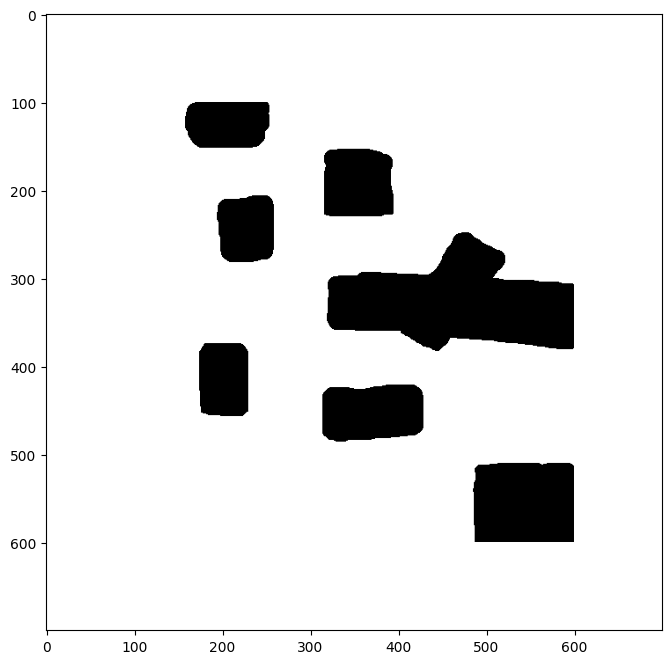

In [9]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('img/cave.png')
#img = 1 - mpimg.imread('img/maze.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

35


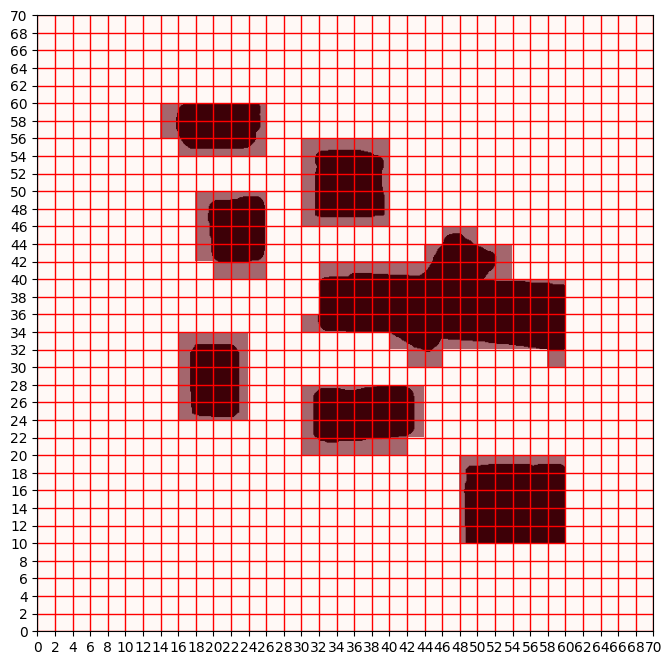

In [10]:
#np.set_printoptions(threshold=np.inf)
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([70, 70]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2

rows, cols = (map_dims / cell_size).astype(int)
print(rows)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (999) ou Não-ocupadas (0)       
grid[grid > threshold] = 999
grid[grid<= threshold] = 0

#print(grid)
#print(grid[5][7])

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

### Algoritmo de wavefront

A premissa é que conhecemos o mapa do ambiente e o goal. Assim, a partir do goal, vamos acrescentar um potencial aos vizinhos de modo que cada ponto no mapa tenha um potencial. A vantagem desse modo é que ele impede minímos locais que poderiam atrapalhar o robô a chegar na posição objetivo.

In [11]:
def wavefront(goal,grid):

    neighboorsPosition = [[-1,+1],[0,+1],[+1,+1],[-1,0],[+1,0],[-1,-1],[0,-1],[+1,-1]]
    
    q = []
    q.append(goal)
    
    potentialGrid = np.copy(grid)
    while len(q) != 0:
        point = q.pop(0)
        x = point[0]
        y = point[1]
        potential = potentialGrid[x][y]
        for px,py in neighboorsPosition:
            neighboorX = px + x
            neighboorY = py + y
            if neighboorX > rows-1 or neighboorY > cols-1:
                continue
            if neighboorX < 0 or neighboorY < 0:
                continue
            if neighboorX == goal[0] and neighboorY == goal[1]:
                continue
            if potentialGrid[neighboorX][neighboorY] == 0:
                potentialGrid[neighboorX][neighboorY] = potential + 1
                q.append([x+px,y+py])
    return potentialGrid

Setando o objetivo para a posição (0,0) por exemplo:

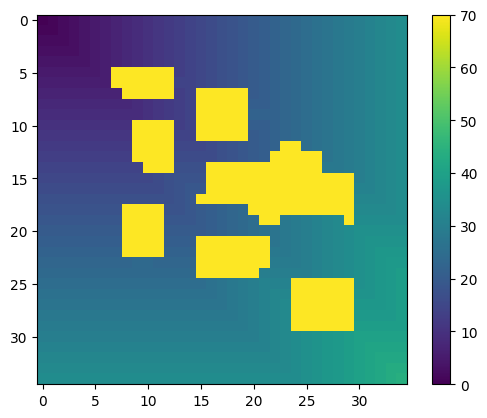

In [12]:
goal = np.array([0,0])
potentialGrid = wavefront(goal,grid)
plt.imshow(potentialGrid, origin='upper', vmin=0, vmax=70)

ax.set_xticks(np.arange(0, cols, cell_size))
ax.set_yticks(np.arange(0, rows, cell_size))

plt.colorbar()


Dessa forma, o robô em qualquer posição desse grid de potencial conseguiria chegar ao goal saindo da célula em que se encontra para alguma célula vizinha de potencial menor. Vale destacar que foi utilizado uma vizinhança de 8, ou seja, assume que o robô se movimentar de maneira diagonal não é um problema. 

### Algoritmo de Encontrar o caminho

In [13]:
def findPath(robotPosition,goal,potentialGrid):
    neighboorsPosition = [[-1,+1],[0,+1],[+1,+1],[-1,0],[+1,0],[-1,-1],[0,-1],[+1,-1]]
    q = []
    q.append(robotPosition)

    path = []
    
    while len(q) != 0:
        point = q.pop(0)
        x = point[0]
        y = point[1]
        potential = potentialGrid[x][y]
        for px,py in neighboorsPosition:
            neighboorX = px + x
            neighboorY = py + y
            if neighboorX > rows-1 or neighboorY > cols-1:
                continue
            if neighboorX < 0 or neighboorY < 0:
                continue
            if potentialGrid[neighboorX][neighboorY] < potential:
                q.append([x+px,y+py])
                path.append([x+px,y+py])
                break
    return path

Teste com o robô na posição (34,34) e o objetivo na posição (0,0)

In [14]:
robotPosition = np.array([20,20])
goal = np.array([0,0])
path = findPath(robotPosition,goal,potentialGrid)
print(path)

[[19, 19], [18, 18], [18, 17], [18, 16], [18, 15], [17, 14], [16, 13], [15, 12], [15, 11], [15, 10], [14, 9], [13, 8], [12, 8], [11, 8], [10, 8], [9, 9], [8, 8], [7, 7], [6, 6], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1], [0, 0]]


Colocando no colormap para fácil visualização

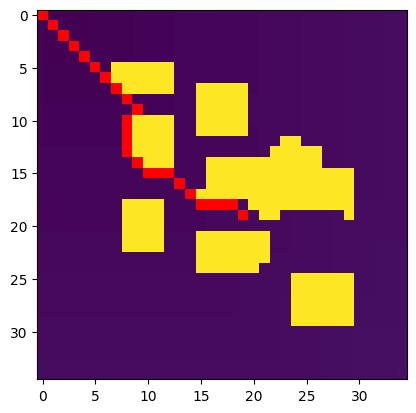

In [15]:
pathGrid = np.copy(potentialGrid)
for x,y in path:
    pathGrid[x][y] = -1

value = -1

masked_array = np.ma.masked_where(pathGrid == value, pathGrid)

cmap = plt.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='red')

plt.imshow(masked_array, cmap=cmap)
plt.show()

### Controlador

Como se trata da implementação de um robô diferencial precisamos implementar um controlador para sua correta execução. O controlador escolhido foi ([De Luca e Oriolo, 1994]).

In [17]:
print ('Program started')
client = RemoteAPIClient()
sim = client.require('sim')
sim.startSimulation()

# Handle para as juntas das RODAS
l_wheel = sim.getObject("/Pioneer_p3dx/Pioneer_p3dx_leftMotor")
r_wheel = sim.getObject("/Pioneer_p3dx/Pioneer_p3dx_rightMotor")

# Handle do Robo
robotHandle = sim.getObject("/Pioneer_p3dx")

# Esse ponto é a posição do robô em relação ao mundo
robotPosition = getPosition(robotHandle)

# World Handle 
worldHandle = sim.handle_world

# Goal position (x, y)
pgoal = np.array([0, 0])

# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros
maxv = 1.0
maxw = np.deg2rad(45)
rho = np.inf

while rho > .05:

    # Fazendo a leitura da posição
    # Esse ponto é a posição do robô em relação ao mundo
    robotPosition = getPosition(robotHandle)

    # Fazendo a leitura da orientação
    robotOrientation = getEulerAngles(robotHandle)

    robotConfig = np.array([robotPosition[0], robotPosition[1], robotOrientation[2]])

    dx, dy = pgoal - robotConfig[:2]

    # Apenas para interromper o loop
    rho = np.sqrt(dx**2 + dy**2)

    kr = 1
    kt = 2
    
    v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
    w = kt*(np.arctan2(dy,dx) - robotConfig[2])

    # Limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw)

    vr = ((2.0*v) + (w*L))/(2.0*r)
    vl = ((2.0*v) - (w*L))/(2.0*r)
    
    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, vl)
    sim.setJointTargetVelocity(r_wheel, vr)
    sim.step()

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)    

sim.stopSimulation()
print ('Program ended')

Program started
Program ended
